（1）估算确定接收板（电流采集板）的有效面积和形状
估算确定秉持的原则是：从入射孔径照射到“整个”接口孔径的光线，也能够照射到接收板上，被接收板所收集。“接口孔径”又称limiting aperture，是探头前半段（high-voltage modulator sub-assembly，高压调制器子组件）和后半段（collector plate sub-assembly，收集板子组件）中间接驳的地方。
估算确定的方案思路：（a）将接口孔径的中心当做“小孔”，对入射孔径的形状大小，进行成像，成在接收板所在的平面上，得到入射孔径的小孔成像（image of entrance aperture on the collector plate）；（b）将沿着小孔成像的像边缘，看做是接口孔径中心投影点的排列，画出接口孔径投影的排列，将这些排列的外包络连起来，形成外围边界；（c）将这个外围边界看成是接收板的接收面积和形状，其大于接收板的有效面积和形状（即接收板接收来自接口孔径全孔照射的有效面积）。

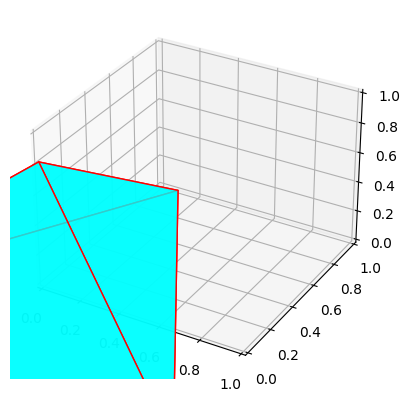

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mplcursors
import pyvista as pv 

class Tetrahedron:
    def __init__(self, side_length_base, side_length_side, top_vertex):
        self.side_length_base = side_length_base
        self.side_length_side = side_length_side
        self.top_vertex = np.array(top_vertex)
        
    def calculate_base_height(self):
        return (self.side_length_base * np.sqrt(3)) / 2

    def calculate_side_height(self):
        return np.sqrt(self.side_length_side ** 2 - (self.side_length_base / 2) ** 2)
        
    def calculate_height(self):
        base_height = self.calculate_base_height()
        side_height = self.calculate_side_height()
        height = np.sqrt(side_height ** 2 - (base_height / 3) ** 2)
        return height

    def calculate_volume(self):
        return (self.side_length_base * self.calculate_base_height()) * self.calculate_height() / 6

    def calculate_surface_area(self):
        return np.sqrt(3) / 4 * (self.side_length_base ** 2)

    def calculate_base_triangle_vertices(self):
        height = self.calculate_height()
        center = [0,0,-height] + self.top_vertex
        side_length = self.side_length_base
        base_height = self.calculate_base_height()
        vertices = [
            (center[0] - side_length / 2, center[1] - base_height / 3, center[2]),
            (center[0] + side_length / 2, center[1] - base_height / 3, center[2]),
            (center[0], center[1] + 2 * base_height / 3, center[2])
            ]
        return vertices

    def project_triangle(self, vertices, projection_point):
        projected_vertices = []
        for vertex in vertices:
            direction = vertex - projection_point
            projected_vertex = projection_point + direction * (self.calculate_height() / direction[2])
            projected_vertices.append(projected_vertex)
        return projected_vertices


# 定义侧边边长、底边边长、上顶点的坐标和额外投影点的坐标
side_length_base = 2.0  # 底边边长
side_length_side = 1.5  # 侧边边长
top_vertex = (0, 0, np.sqrt(6) / 3)  # 上顶点的坐标
projection_point = np.array([0, 0, 0.5])  # 额外投影点的坐标（这里所谓额外投影点的额外二字是针对四面体的四个点而言是额外的，额外投影点是指其中一个侧面作为入射孔径所对应的接收孔径的中心点）

# 创建四面体实例
tetrahedron = Tetrahedron(side_length_base, side_length_side, top_vertex)

# 计算四面体的三个侧面的三角形投影顶点坐标
base_triangle_vertices = tetrahedron.calculate_base_triangle_vertices()
projected_base_triangle = tetrahedron.project_triangle(base_triangle_vertices, projection_point)

# 绘制图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制四面体
vertices = np.array([top_vertex] + base_triangle_vertices)
faces = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
tetrahedron = [[vertices[i] for i in face] for face in faces]
tetra_case = ax.add_collection3d(Poly3DCollection(tetrahedron, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.8))

plt.show()

In [2]:
# 创建PyVista的Plotter对象
plotter = pv.Plotter(notebook=True)

# 绘制四面体
tetrahedron_mesh = pv.PolyData(np.vstack([top_vertex] + base_triangle_vertices))
tetrahedron_mesh.faces = np.hstack([[3, a, b, c] for a, b, c in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]])
plotter.add_mesh(tetrahedron_mesh, color='cyan', opacity=0.8, show_edges=True)

# 绘制额外投影点
projection_mesh = pv.PolyData(projection_point.reshape(1, 3))
plotter.add_mesh(projection_mesh, color='g', point_size=10)

# 绘制投影三角形
projected_triangle_mesh = pv.PolyData(np.vstack([projected_base_triangle]))
projected_triangle_mesh.faces = np.hstack([[3, a, b, c] for a, b, c in [[0,1,2]]])
plotter.add_mesh(projected_triangle_mesh, color='yellow', opacity=0.5, show_edges=True)

# 设置图形参数
plotter.background_color = 'white'
plotter.show_axes()

# 显示图形并启用交互
plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)